In [1]:
import os
import functools
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import pil_to_tensor
from huggingface_hub import hf_hub_download
from PIL import Image, ImageShow
import PIL
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.utils import make_image_grid
from IPython.core.debugger import Pdb
import cv2
import numpy as np
from src.models.attention_processor import SkipAttnProcessor
from src.pipelines.spacat_pipeline import TryOnPipeline
from src.dataset.vitonhd import VITONHDDataset
from src.utils import get_project_root, show, init_attn_processor

# Mask
from PIL import Image
from diffusers.utils import make_image_grid
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import numpy as np
from src.preprocess.humanparsing.run_parsing import Parsing
from src.preprocess.openpose.run_openpose import OpenPose
from src.utils.mask import get_mask_location

# densepose
import pprint
import os
import runpy
import sys
from PIL import Image
from einops import rearrange
import numpy as np
from src.preprocess import apply_net
from src.utils import get_project_root

In [2]:
h, w = (512, 384)

In [3]:
def merge(
    img1: PIL.Image.Image,
    img2: PIL.Image.Image
) -> PIL.Image.Image:
    assert img1.size[1] == img2.size[1]
    h, w = img1.size[1], img1.size[0]
    w2 = img2.size[0]
    img = Image.new('RGB', (w + w2, h))
    img.paste(img1, (0, 0))
    img.paste(img2, (w, 0))
    return img

In [4]:
def apply_poisson_blending(
    original_img: PIL.Image.Image,
    tryon_img: PIL.Image.Image,
    mask_img: PIL.Image.Image
) -> PIL.Image.Image:
    w, h = original_img.size
    original_img = np.array(original_img)
    tryon_img = np.array(tryon_img)
    mask_img = np.array(mask_img)
    mask_img = 255 - mask_img
    output = cv2.seamlessClone(original_img, tryon_img, mask_img, (w//2, h//2), cv2.NORMAL_CLONE)
    return Image.fromarray(output, mode='RGB')

In [5]:
""" Download models from Huggingface Hub
"""
PROJECT_ROOT_PATH = get_project_root()
repo_id = 'bui/Navier-1'
base_folder = 'ckpt-170000'

# unet
unet_path = hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'unet'),
    filename='diffusion_pytorch_model.safetensors',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'unet'),
    filename='config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)

# vae
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'vae'),
    filename='diffusion_pytorch_model.safetensors',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'vae'),
    filename='config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
# scheduler
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'scheduler'),
    filename='scheduler_config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
# model_index.json
hf_hub_download(
    repo_id=repo_id,
    subfolder=base_folder,
    filename='model_index.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)

model_root_path = os.path.dirname(os.path.dirname(unet_path))
model_root_path

'/home/jupyter/H-engine/checkpoints/navier-1/ckpt-170000'

In [6]:
vae = AutoencoderKL.from_pretrained(
    model_root_path,
    subfolder='vae',
    torch_dtype=torch.float16
)
scheduler = DDPMScheduler.from_pretrained(
    model_root_path,
    subfolder='scheduler'
)

unet = UNet2DConditionModel.from_pretrained(
    model_root_path,
    subfolder='unet',
    torch_dtype=torch.float16
)
init_attn_processor(unet, cross_attn_cls=SkipAttnProcessor)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
gpu_id = 0
human_parser = Parsing(gpu_id)
openpose = OpenPose(gpu_id)

/home/jupyter/H-engine/src/preprocess/openpose/annotator/openpose/body.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load

In [18]:
testset = VITONHDDataset(
    data_rootpath=os.path.join(PROJECT_ROOT_PATH, 'datasets', 'vitonhd'),
    use_trainset=True,
    height=h,
    width=w,
    use_CLIPVision=True
)

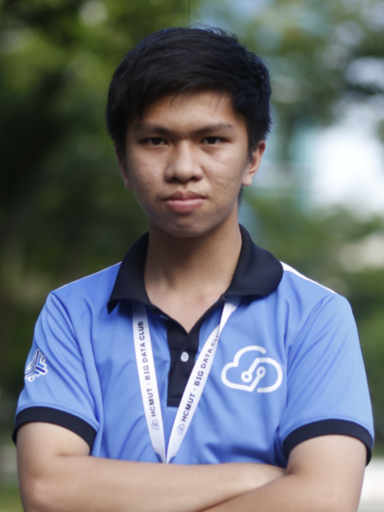

In [9]:
img_path = '../assets/man11.jpg'
img = Image.open(img_path).resize((w, h))
# img = Image.open(img_path)
# img = PIL.ImageOps.cover(img, (w, h))
img

In [10]:
img.size

(384, 512)

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


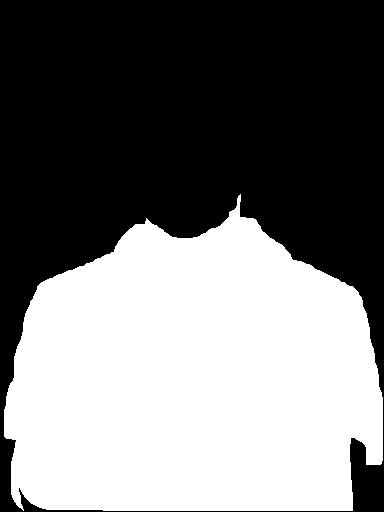

In [11]:
keypoints = openpose(img)
body_parse, _  = human_parser(img)
mask_img, _ = get_mask_location(
    model_type='hd',
    category='upper_body',
    model_parse=body_parse,
    keypoint=keypoints,
    width=w,
    height=h
)
mask_img

/home/jupyter/H-engine/.venv38/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


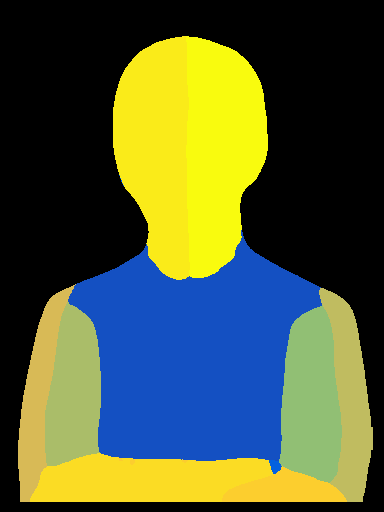

In [12]:
args = apply_net.create_argument_parser().parse_args((
    'show',
    '../configs/densepose_rcnn_R_50_FPN_s1x.yaml',
    '../checkpoints/densepose/model_final_162be9.pkl',
    img_path,
    'dp_segm',
    '-v'
))
densepose_np, instances, matrix_vis, mask_bg, _ = args.func(args, img)
Image.fromarray(densepose_np[:, :, ::-1])

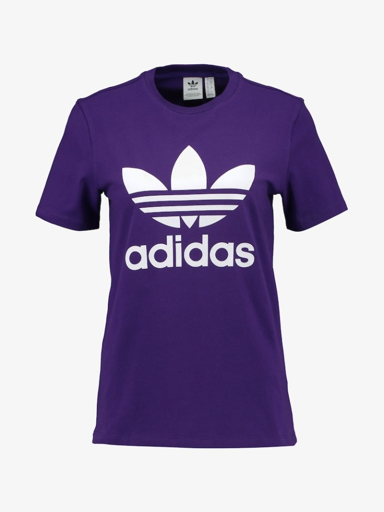

In [49]:
idx = 32
outfit = Image.open(testset[idx]['original_cloth_path']).resize((w, h))
outfit

In [55]:
mask = pil_to_tensor(mask_img).unsqueeze(0)
densepose = torch.from_numpy(densepose_np).permute(2, 0, 1).unsqueeze(0)
cloth = testset[idx]['cloth_raw'].unsqueeze(0)
image = VITONHDDataset.preprocess(img, w, h).unsqueeze(0)

print(f'mask: {mask.shape}')
print(f'densepose: {densepose.shape}')
print(f'cloth: {cloth.shape}')
print(f'img: {image.shape}')

mask: torch.Size([1, 1, 512, 384])
densepose: torch.Size([1, 3, 512, 384])
cloth: torch.Size([3, 512, 384])
img: torch.Size([1, 3, 512, 384])


In [56]:
pipe = TryOnPipeline(
    unet=unet,
    vae=vae,
    scheduler=scheduler
).to(device)

with torch.inference_mode():
    with torch.amp.autocast(device):
        images = pipe(
            image=image.to(device),
            mask_image=mask.to(device),
            densepose_image=densepose.to(device),
            cloth_image=cloth.to(device),
            height=h,
            width=w,
            generator=torch.manual_seed(1996),
        ).images

del pipe
torch.cuda.empty_cache()

/home/jupyter/H-engine/.venv38/lib/python3.8/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `vae_latent_channels` directly via 'VaeImageProcessor' object attribute is deprecated. Please access 'vae_latent_channels' over 'VaeImageProcessor's config object instead, e.g. 'scheduler.config.vae_latent_channels'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/jupyter/H-engine/.venv38/lib/python3.8/site-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-0.9607843160629272,1.0]
  warnings.warn(
/home/jupyter/H-engine/.venv38/lib/python3.8/site-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expecte

  0%|          | 0/50 [00:00<?, ?it/s]

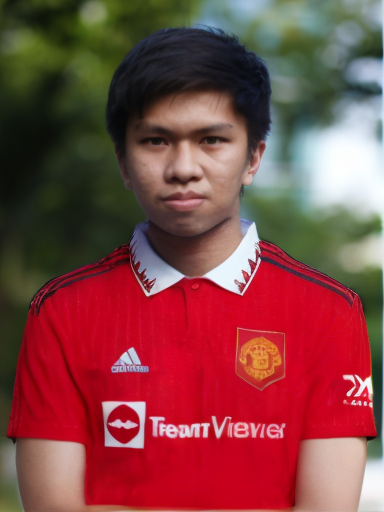

In [57]:
images[0]

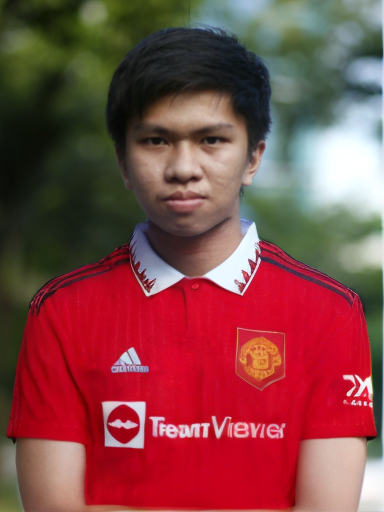

In [58]:
poisson = apply_poisson_blending(img, images[0], mask_img)
poisson

In [60]:
save_path = os.path.join(PROJECT_ROOT_PATH, 'results', 'navier-1', 'beta', 'final', 'in_the_wilds')
os.makedirs(save_path, exist_ok=True)
img_name = img_path.split('.')[-2].split('/')[-1]

fname = f'{img_name}-{idx}.png'
images[0].save(Path(save_path, fname))

fname = f'{img_name}-{idx}-poisson.png'
poisson.save(Path(save_path, fname))

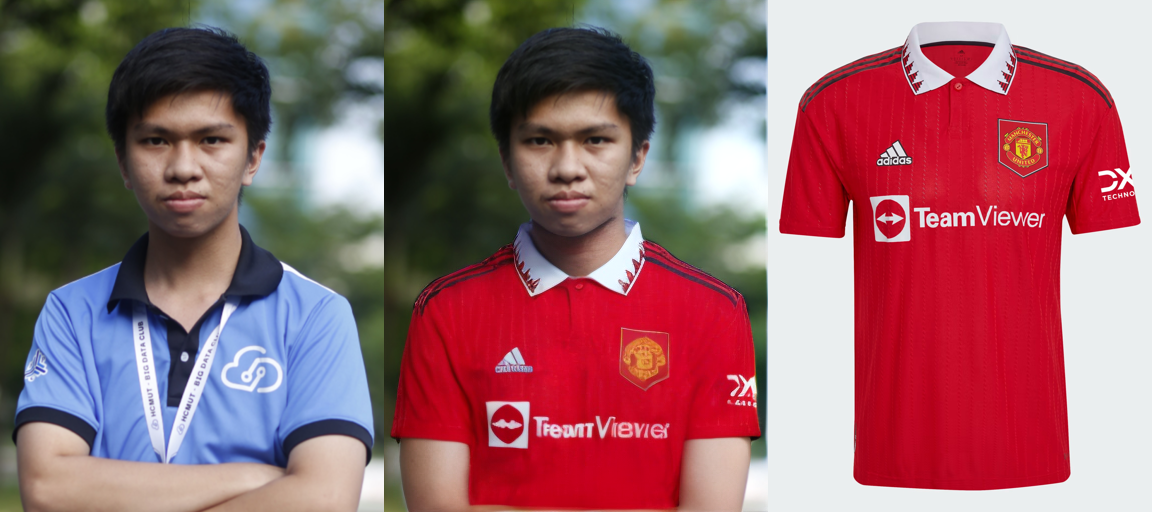

In [61]:
original_image = Image.open('../assets/man10.jpg').resize((w, h))
tryon_img = Image.open('../results/navier-1/beta/final/in_the_wilds/man10-7-poisson.png').resize((w, h))
original_cloth = Image.open(testset[7]['original_cloth_path']).resize((w, h))

out = functools.reduce(merge, [original_image, tryon_img, original_cloth])
fname = 'merged-man10-7-poisson.png'
out.save(Path(save_path, fname))
out